In [249]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import itertools
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import cv2
from IPython.display import display, Image, clear_output
import ipywidgets as widgets
import threading
from sklearn.metrics import f1_score, recall_score


cudnn.benchmark = True
plt.ion()   # interactive mode

In [250]:
# ADAPTED FROM THE PROFESSOR'S PYTORCH NOTEBOOK

# For straightforward datasets, sometimes you can make do with built-in PyTorch dataset objects.
# We want to apply automated data augmentations, which will be different for the training
# and eval scenarios

data_transforms = {
    x: transforms.Compose([
#         transforms.ToPILImage(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.01, .5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    for x in ['train', 'val']
}

data_transforms['test'] = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [251]:
data_dir = './data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test', 'val']}

In [252]:
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0, drop_last=True)
              for x in ['train', 'test', 'val']}

In [253]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test', 'val']}
class_names = image_datasets['train'].classes

print(dataset_sizes)
print(class_names)

{'train': 1619, 'test': 100, 'val': 170}
['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [254]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [255]:
print(torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
print(torch.backends.mps.is_built()) #MPS is activated

True
True


In [256]:
# Let’s visualize a few training images so as to understand the data augmentations.
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

torch.Size([4, 3, 299, 299])
tensor([19,  0, 14,  1])
torch.Size([3, 303, 1206])


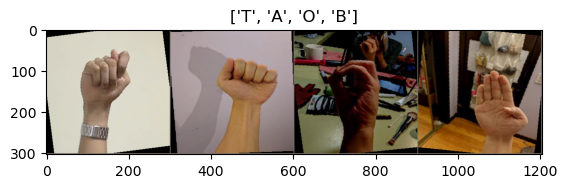

In [257]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)
print(classes)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
print(out.shape)

imshow(out, title=[class_names[x] for x in classes])

In [258]:
# Now, let’s write a general function to train a model.
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [259]:
# Load a pretrained model and reset final fully connected layer for this particular classification problem.
model_resnet = models.resnet18(weights=True)

model_inception = models.inception_v3(weights=models.Inception_V3_Weights.IMAGENET1K_V1)
model_inception.aux_logits=False

# model_mobilenet = models.mobilenet_v3_small(pretrained=True)

trained_models = {
    "resnet": model_resnet,
    "inception": model_inception,
#     "mobilenet": model_mobilenet
}



for k in trained_models.keys():
    num_ftrs = trained_models[k].fc.in_features
    trained_models[k].fc = nn.Linear(num_ftrs, len(class_names))
    trained_models[k] = trained_models[k].to(device)
    

In [260]:
# Let's set our loss function
criterion = nn.CrossEntropyLoss()

In [ ]:
# for k in trained_models.keys():
for k in ['resnet', 'inception']:
    print(f"TRAINING {k}")
    # setup the optimizer to update the model parameters
    optimizer_ft = optim.SGD(trained_models[k].parameters(), lr=0.0005, momentum=0.9)
    
    # decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
                                           
    # train and evaluate.
    trained_models[k] = train_model(trained_models[k], criterion, optimizer_ft, exp_lr_scheduler,
                           num_epochs=10)
    print("\n\n\n")                        

TRAINING resnet
Epoch 0/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:34<00:00,  4.29it/s]


train Loss: 2.9348 Acc: 0.1686


100%|███████████████████████████████████████████████| 42/42 [00:03<00:00, 10.98it/s]


val Loss: 1.9759 Acc: 0.4353

Epoch 1/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:32<00:00,  4.37it/s]


train Loss: 1.7584 Acc: 0.5355


100%|███████████████████████████████████████████████| 42/42 [00:04<00:00, 10.26it/s]


val Loss: 1.0011 Acc: 0.7000

Epoch 2/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:34<00:00,  4.29it/s]


train Loss: 1.0117 Acc: 0.7671


100%|███████████████████████████████████████████████| 42/42 [00:04<00:00, 10.15it/s]


val Loss: 0.6016 Acc: 0.7706

Epoch 3/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:34<00:00,  4.29it/s]


train Loss: 0.6481 Acc: 0.8758


100%|███████████████████████████████████████████████| 42/42 [00:04<00:00, 10.29it/s]


val Loss: 0.4762 Acc: 0.8118

Epoch 4/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:34<00:00,  4.26it/s]


train Loss: 0.4000 Acc: 0.9296


100%|███████████████████████████████████████████████| 42/42 [00:04<00:00, 10.29it/s]


val Loss: 0.4435 Acc: 0.8412

Epoch 5/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:40<00:00,  4.03it/s]


train Loss: 0.2971 Acc: 0.9444


100%|███████████████████████████████████████████████| 42/42 [00:04<00:00, 10.44it/s]


val Loss: 0.3892 Acc: 0.8412

Epoch 6/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:35<00:00,  4.25it/s]


train Loss: 0.2285 Acc: 0.9617


100%|███████████████████████████████████████████████| 42/42 [00:04<00:00, 10.37it/s]


val Loss: 0.4218 Acc: 0.8471

Epoch 7/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:31<00:00,  4.40it/s]


train Loss: 0.1627 Acc: 0.9747


100%|███████████████████████████████████████████████| 42/42 [00:03<00:00, 10.68it/s]


val Loss: 0.3794 Acc: 0.8706

Epoch 8/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:34<00:00,  4.28it/s]


train Loss: 0.1577 Acc: 0.9784


100%|███████████████████████████████████████████████| 42/42 [00:04<00:00, 10.49it/s]


val Loss: 0.3738 Acc: 0.8529

Epoch 9/9
----------


100%|█████████████████████████████████████████████| 404/404 [01:41<00:00,  3.99it/s]


train Loss: 0.1518 Acc: 0.9765


100%|███████████████████████████████████████████████| 42/42 [00:03<00:00, 10.74it/s]


val Loss: 0.3629 Acc: 0.8765

Training complete in 16m 33s
Best val Acc: 0.876471




TRAINING inception
Epoch 0/9
----------


100%|█████████████████████████████████████████████| 404/404 [02:47<00:00,  2.41it/s]


train Loss: 3.0053 Acc: 0.1594


100%|███████████████████████████████████████████████| 42/42 [00:06<00:00,  6.94it/s]


val Loss: 2.3367 Acc: 0.3588

Epoch 1/9
----------


100%|█████████████████████████████████████████████| 404/404 [02:46<00:00,  2.43it/s]


train Loss: 1.8953 Acc: 0.5040


100%|███████████████████████████████████████████████| 42/42 [00:05<00:00,  7.14it/s]


val Loss: 1.0375 Acc: 0.7353

Epoch 2/9
----------


100%|█████████████████████████████████████████████| 404/404 [02:55<00:00,  2.30it/s]


train Loss: 1.0172 Acc: 0.7591


100%|███████████████████████████████████████████████| 42/42 [00:06<00:00,  6.35it/s]


val Loss: 0.5146 Acc: 0.8294

Epoch 3/9
----------


100%|█████████████████████████████████████████████| 404/404 [02:57<00:00,  2.27it/s]


train Loss: 0.5496 Acc: 0.8826


100%|███████████████████████████████████████████████| 42/42 [00:07<00:00,  5.98it/s]


val Loss: 0.3953 Acc: 0.8529

Epoch 4/9
----------


100%|█████████████████████████████████████████████| 404/404 [02:55<00:00,  2.30it/s]


train Loss: 0.3539 Acc: 0.9265


100%|███████████████████████████████████████████████| 42/42 [00:06<00:00,  6.32it/s]


val Loss: 0.4089 Acc: 0.8765

Epoch 5/9
----------


 52%|███████████████████████▌                     | 212/404 [01:32<01:21,  2.35it/s]

In [ ]:
for k in trained_models.keys():
    print(f"{k} accuracy: {test_model(trained_models[k])}")
    torch.save(trained_models[k].state_dict(), os.path.abspath(f"./models/{k}"))

In [ ]:
# #https://abauville.medium.com/display-your-live-webcam-feed-in-a-jupyter-notebook-using-opencv-d01eb75921d1

# chosen_model = "inception"

# # stop button
# stopButton = widgets.ToggleButton(
#     value=False,
#     description='Stop',
#     disabled=False,
#     button_style='danger',
#     tooltip='Description',
#     icon='square'
# )


# # display function
# def view(button):
#     cap = cv2.VideoCapture(0)
#     display_handle=display(None, display_id=True)
#     i = 0
#     while True:
#         _, frame = cap.read()
#         frame = cv2.flip(frame, 1)
        
#         # crop and resize the frame
#         crop_width, crop_height = 299, 299

#         # Get the dimensions of the image
#         height, width = frame.shape[:2]

#         # Calculate coordinates for the crop
#         start_x = (width - crop_width) // 2
#         start_y = (height - crop_height) // 2

#         # Crop the image
#         cropped_image = frame[start_y:start_y + crop_height, start_x:start_x + crop_width]
        
# #         frame = cv2.resize(frame, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
    
        
#         frame = cropped_image.astype(np.float32)

#         new_frame = data_transforms["test"](frame / 255).unsqueeze(0)

#         with torch.no_grad():
#             pred = class_names[torch.argmax(trained_models[chosen_model](new_frame))] + ' ' + str(torch.max(nn.Softmax()(trained_models[chosen_model](new_frame))).item())
       
#         font = cv2.FONT_HERSHEY_SIMPLEX 
#         cv2.putText(frame,  
#                 pred,  
#                 (50, 50),  
#                 font, 1,  
#                 (0, 255, 255),  
#                 2,  
#                 cv2.LINE_4) 
        
#         _, frame = cv2.imencode('.jpeg', frame)
        
#         display_handle.update(Image(data=frame.tobytes()))
#         if stopButton.value==True:
#             cap.release()
#             display_handle.update(None)

            
# # run
# display(stopButton)
# thread = threading.Thread(target=view, args=(stopButton,))
# thread.start()

## 